In [1]:
import os
import numpy as np
import matplotlib.pyplot as plt

import utils
import forward_model
import globals
import least_squares
import section_search
import coordinate_descent
import initialization

import torch

/data/holly_jackson/miniconda3/envs/dfd-sparse/lib/python3.12/site-packages/gco/__init__.py:7: FutureWarning: In the future `np.bool` will be defined as the corresponding NumPy scalar.
  if not hasattr(numpy, name):


cpu


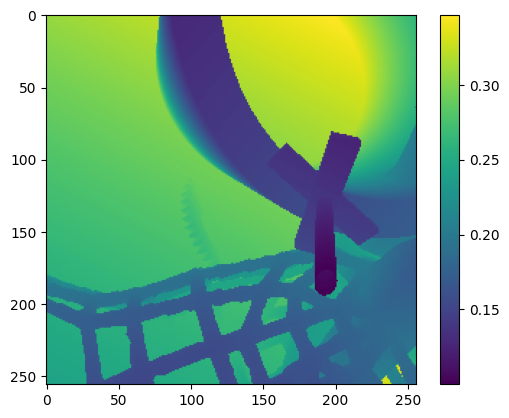

256 256
float16 float32
adaptive kernel size set to 11


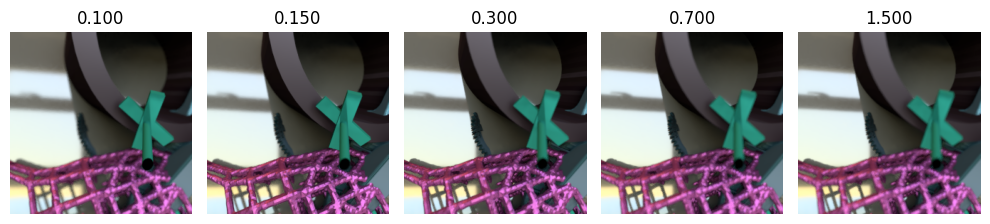

In [2]:
globals.init_DefocusNet()

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

IMAGE_RANGE = 255.

# load data 
gt_dpt, defocus_stack = utils.load_single_sample_DefocusNet()
defocus_stack *= IMAGE_RANGE 

plt.imshow(gt_dpt)
plt.colorbar()
plt.show()

width, height = gt_dpt.shape
print(width, height)
print(gt_dpt.dtype, defocus_stack.dtype)

max_kernel_size = utils.kernel_size_heuristic(width, height)
print('adaptive kernel size set to',max_kernel_size)
utils.update_max_kernel_size(max_kernel_size)

utils.plot_single_stack(defocus_stack / IMAGE_RANGE, globals.Df)


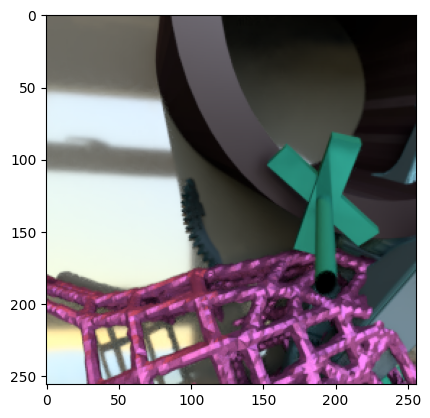

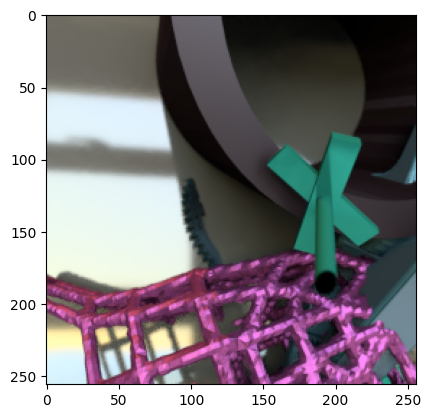

In [3]:
# AIF initialization

# aif_init = initialization.trivial_aif_initialization(defocus_stack)
aif_init = initialization.compute_aif_initialization(defocus_stack, lmbda=0.05,
                                                     sharpness_measure='sobel_grad')
plt.imshow(aif_init / IMAGE_RANGE)
plt.show()

plt.imshow(defocus_stack[1] / IMAGE_RANGE)
plt.show()

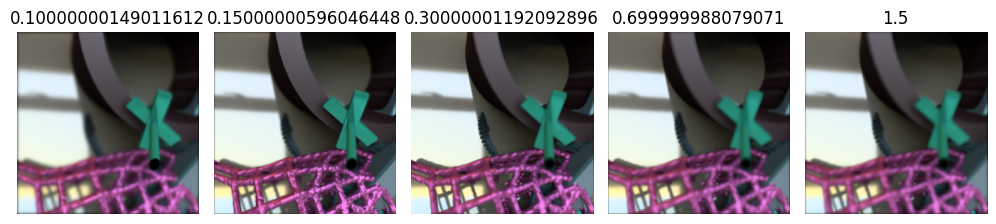

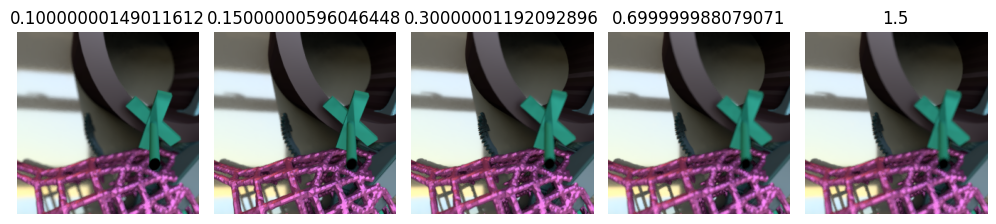

0 --> 2.3658203982590553e-05


In [4]:
# sanity check 

globals.thresh = 0
test_defocus_stack_none = forward_model.forward(gt_dpt, aif_init)
# globals.thresh = 0.5
# test_defocus_stack_05 = forward_model.forward(gt_dpt, aif_init)
# globals.thresh = 1
# test_defocus_stack_1 = forward_model.forward(gt_dpt, aif_init)
# globals.thresh = 2
# test_defocus_stack_2 = forward_model.forward(gt_dpt, aif_init)

utils.plot_single_stack(test_defocus_stack_none / IMAGE_RANGE, globals.Df)
# utils.plot_single_stack(test_defocus_stack_05 / IMAGE_RANGE, globals.Df)
# utils.plot_single_stack(test_defocus_stack_1 / IMAGE_RANGE, globals.Df)
# utils.plot_single_stack(test_defocus_stack_2 / IMAGE_RANGE, globals.Df)
utils.plot_single_stack(defocus_stack / IMAGE_RANGE, globals.Df)

print('0 -->', np.mean(defocus_stack / IMAGE_RANGE - test_defocus_stack_none / IMAGE_RANGE)**2)
# print('0.5 -->', np.mean(defocus_stack / IMAGE_RANGE - test_defocus_stack_05 / IMAGE_RANGE)**2)
# print('1 -->', np.mean(defocus_stack / IMAGE_RANGE - test_defocus_stack_1 / IMAGE_RANGE)**2)
# print('2 -->', np.mean(defocus_stack / IMAGE_RANGE - test_defocus_stack_2 / IMAGE_RANGE)**2)


Created experiment folder: /data/holly_jackson/experiments/defocus-net-000373_2025-11-03_23-21-44
Images in range [0-255]


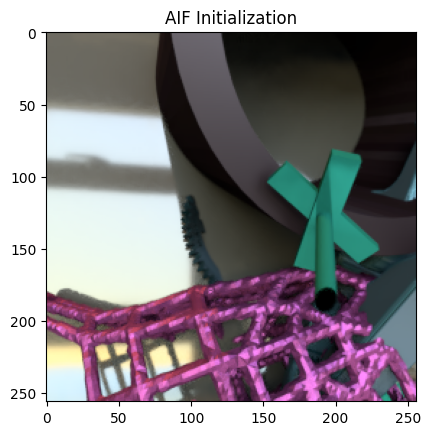

Iteration 0 



Grid search         : 100%|███████████████████| 100/100 [00:12<00:00,  7.85it/s]


GRID SEARCH DURATION 12.887344598770142


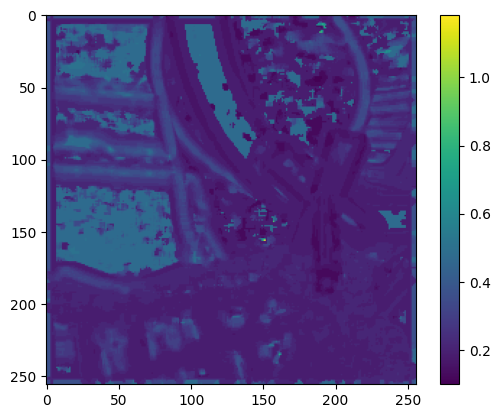


Golden-section search...
...searching for 100 % convergence
...done
GSS DURATION 8.87932825088501


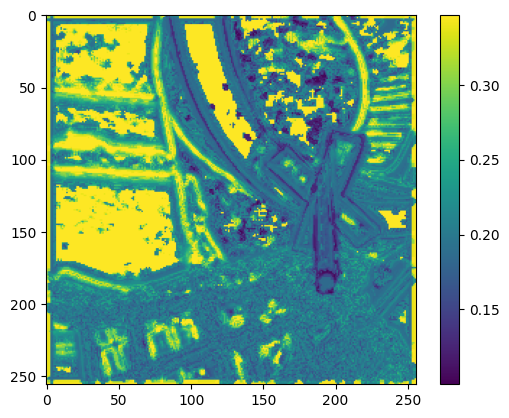

Loss: 60.118935 , TV: 3437.0244

DPT result range: [ 0.10345756 , 1.1588192 ]


Bounded FISTA...


Optimizing: 100%|█████████████████████████████| 200/200 [01:23<00:00,  2.39it/s]


r1norm 6237.915 norm(x) 57577.15
FISTA duration 87.48075103759766

AIF result range: [ 0.0 , 255.0 ]
Loss: 39.584244 , TV: 3326612.0


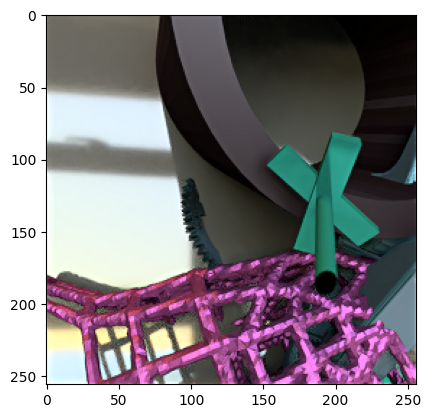

FULL ITER DURATION 111.88933992385864
ls_maxiter updated to 210


--------------------------



In [6]:
# -------------------
# COORDINATE DESCENT
# -------------------

globals.thresh = 0.5
globals.window_size = 5

dpt, aif, _, _ = coordinate_descent.coordinate_descent(defocus_stack,
        experiment_folder='/data/holly_jackson/experiments',
        show_plots=True, save_plots=False,
        experiment_name = 'defocus-net-000373', num_epochs = 1,
        # least_squares_first=True, depth_init=depth_init,
        least_squares_first = False, aif_init = aif_init,                                             
        k = 1, aif_method = 'fista',
        finite_differences = False, num_Z = 100, 
        ls_maxiter = 200, ls_maxiter_multiplier = 1.05, 
        min_Z = 0.1, max_Z = 3,
        vmin = gt_dpt.min(), vmax = gt_dpt.max(), verbose = True,
        windowed_mse = True)


RMS 0.100948736
Rel 0.3207432
{'delta1': 0.4880218505859375, 'delta2': 0.8033599853515625, 'delta3': 0.94647216796875}


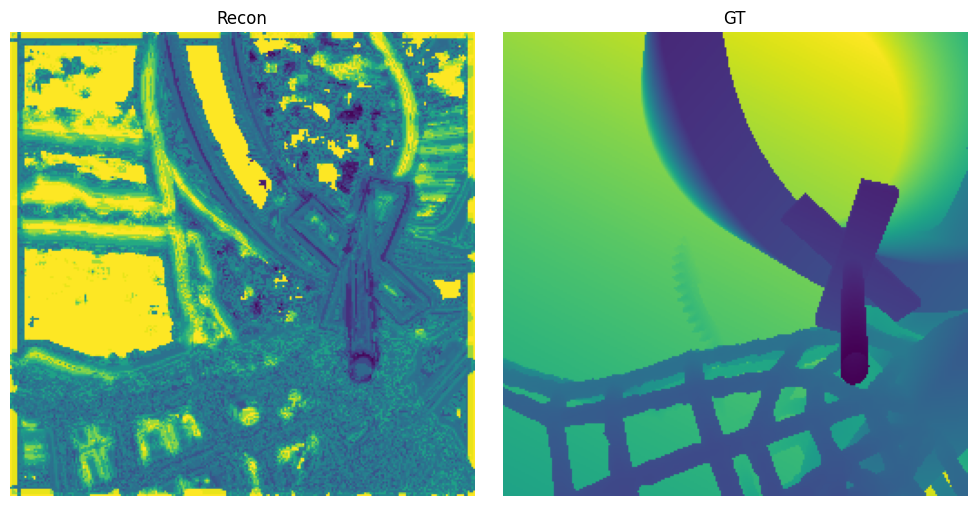

In [7]:
print('RMS', utils.compute_RMS(dpt, gt_dpt))
print('Rel', utils.compute_Rel(dpt, gt_dpt))
print(utils.compute_accuracy_metrics(dpt, gt_dpt))

utils.plot_compare_greyscale(dpt, gt_dpt, vmin=gt_dpt.min(), vmax=gt_dpt.max())


# todo: fista check if A @ x is quicker stacked or in loop

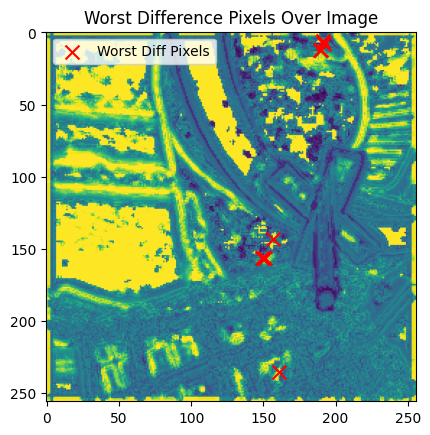

In [7]:
worst_coords = utils.get_worst_diff_pixels(dpt, gt_dpt, num_worst_pixels=10, vmin=gt_dpt.min(), vmax=gt_dpt.max())

k = 10  # top-k best (smallest diffs)

diff = np.abs(dpt - gt_dpt)
flat = diff.ravel()

# k smallest indices (unsorted), then sort them by value ascending
best_idx = np.argpartition(flat, k)[:k]
best_idx = best_idx[np.argsort(flat[best_idx])]

# 2D coordinates (row, col), sorted by increasing diff
rows, cols = np.unravel_index(best_idx, diff.shape)
best_coords = list(zip(rows, cols))

In [10]:
depth_maps, Z, k_min_indices, all_losses = section_search.grid_search_opt_k(
    aif, defocus_stack,
    indices = None, min_Z = 0.1, max_Z = 3, num_Z = 100, k = 1, windowed=True)

print(k_min_indices.shape)

Grid search         : 100%|███████████████████| 100/100 [00:12<00:00,  7.79it/s]


(256, 256, 1)


3 0.18787879 0.002180688 -0.0011533126
4 0.21717171 -0.0011533126 -0.0027805269
8 0.33434343 0.0020150542 -0.0003729239
9 0.36363637 -0.0003729239 0.00046683848
10 0.3929293 0.00046683848 0.0018586665
14 0.510101 -0.002024144 -0.001977712
20 0.6858586 7.9870224e-05 0.00013509393


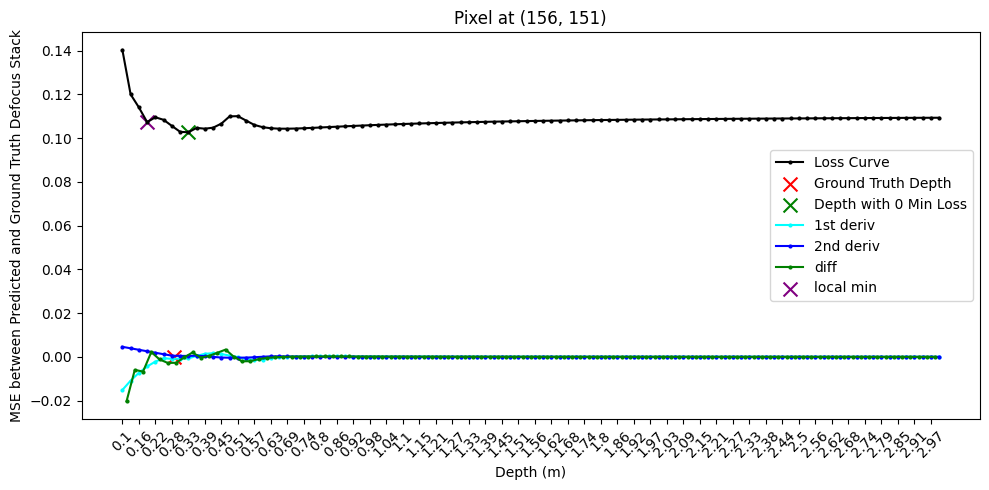

3 0.18787879 0.012005188 0.0018564761
5 0.24646464 -0.0011470392 -0.0019484907
8 0.33434343 0.0016917884 -0.0010435507
9 0.36363637 -0.0010435507 -0.0005483255
11 0.42222223 0.00057433546 0.0019942
14 0.510101 -0.002395302 -0.0024218932
21 0.7151515 1.8537045e-05 6.444007e-05


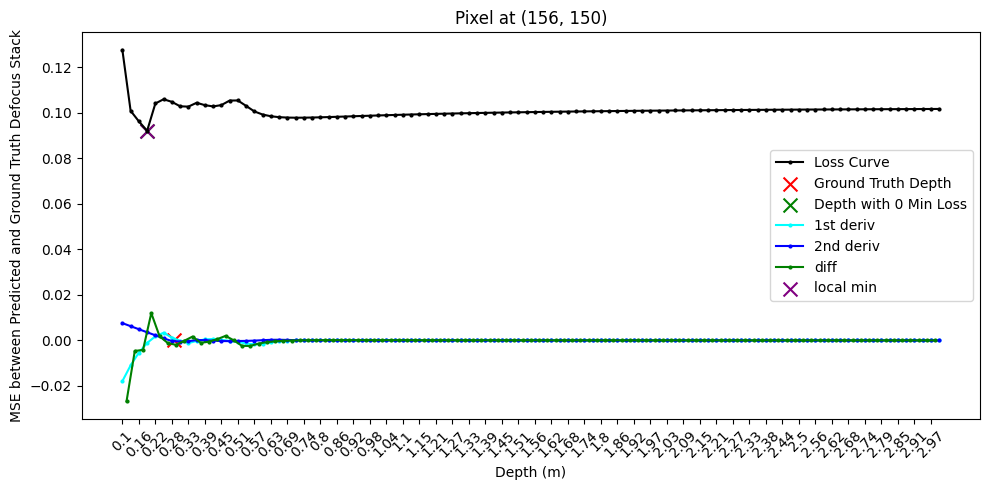

8 0.33434343 0.00069229305 -0.00056028366
9 0.36363637 -0.00056028366 -2.9735267e-05
11 0.42222223 0.00076761097 0.0015957654
13 0.48080808 -0.00015013665 -0.0008645877
17 0.5979798 1.8499792e-05 0.00012931973


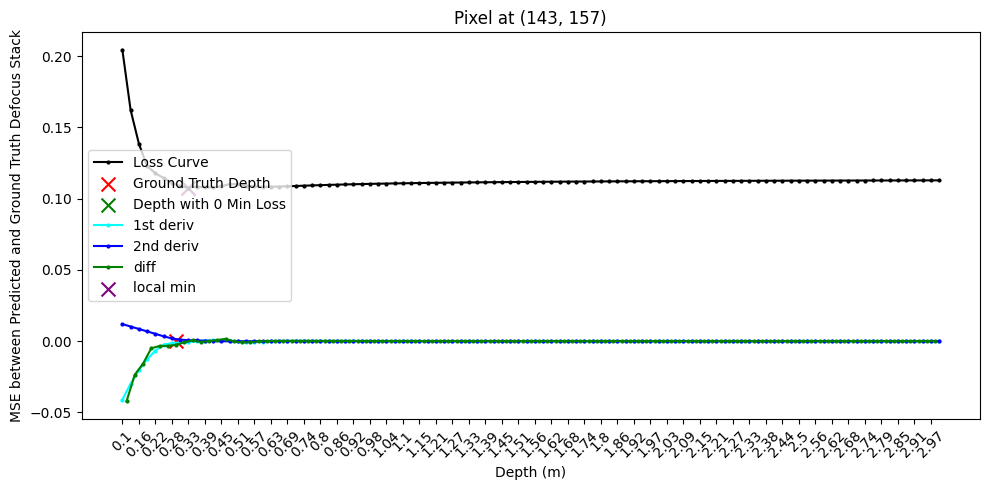

12 0.45151514 0.00048256665 -0.0004226938
13 0.48080808 -0.0004226938 -0.0011864007
20 0.6858586 2.9847026e-05 4.6633184e-05


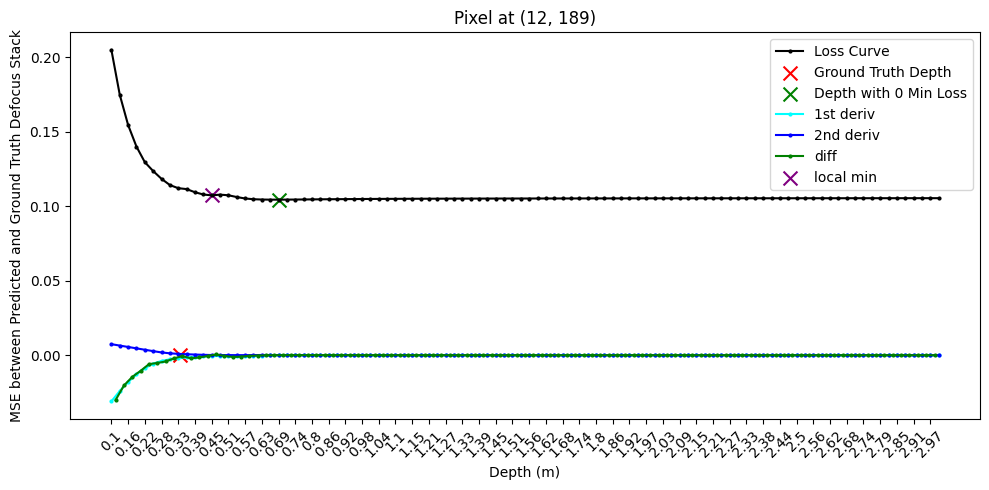

11 0.42222223 3.5762787e-05 0.0011807159
13 0.48080808 -0.00031864643 -0.0012432486
20 0.6858586 1.6830862e-05 3.6917627e-05


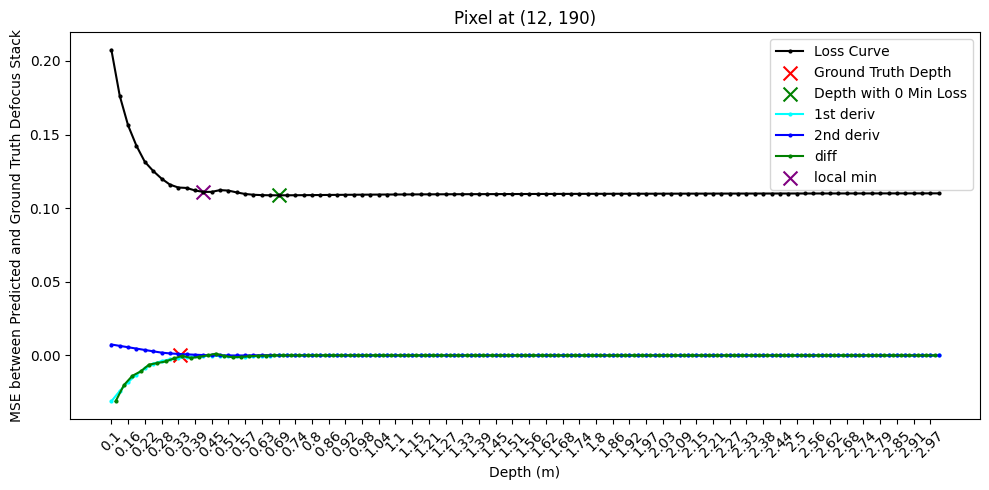

12 0.45151514 0.0009448752 3.938377e-05
14 0.510101 -0.0024082735 -0.00239937
21 0.7151515 6.509572e-05 0.0001032725


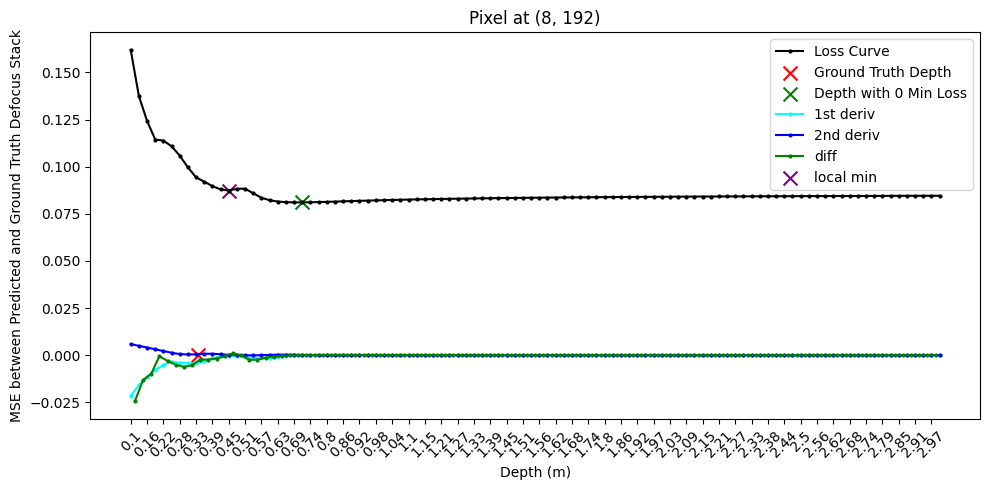

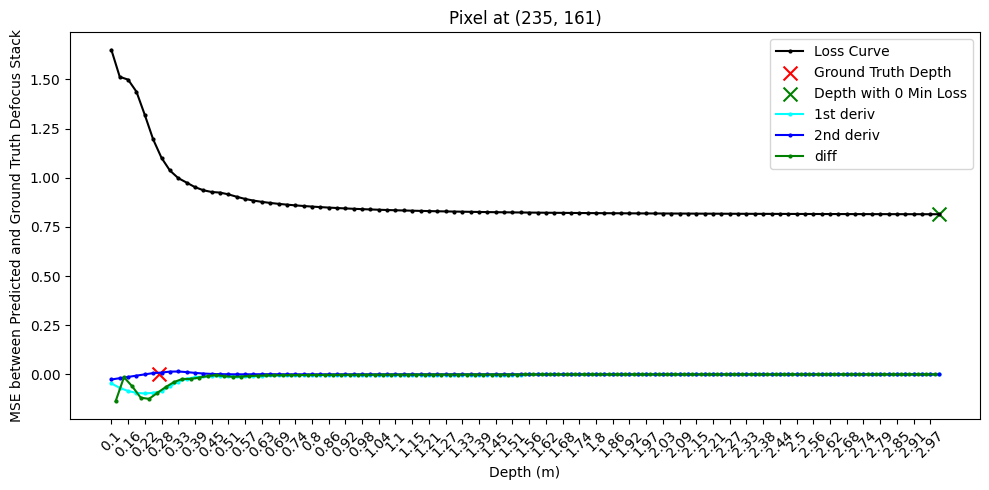

12 0.45151514 8.197129e-05 -0.00013003498
13 0.48080808 -0.00013003498 -0.00258445
22 0.74444443 3.7550926e-05 7.0519745e-05


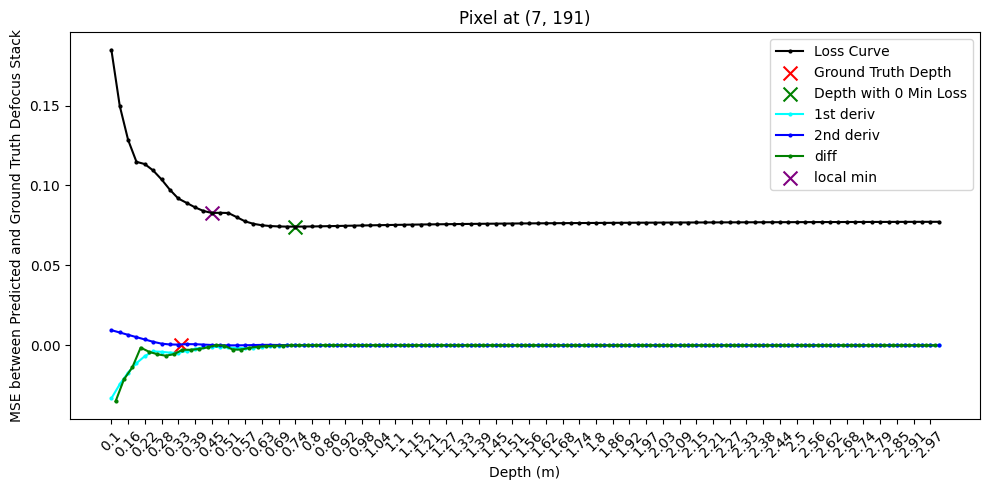

3 0.18787879 0.006506622 0.00198403
5 0.24646464 -0.00062690675 -0.0014753789
7 0.3050505 5.19529e-05 0.0015055686
9 0.36363637 -0.0011858568 -0.00088596344
12 0.45151514 0.0012193322 0.00010715425
14 0.510101 -0.0015728101 -0.0015021265
19 0.65656567 7.431209e-05 0.00014511496


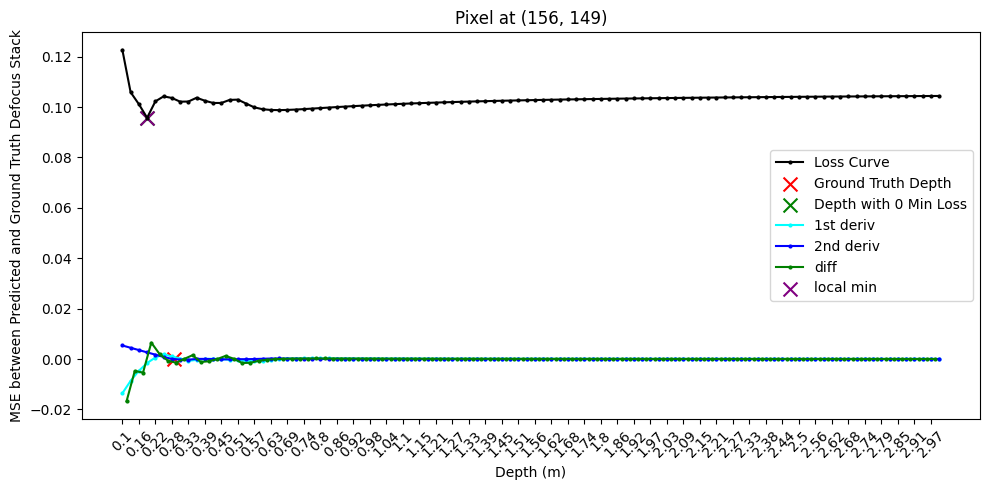

12 0.45151514 0.00050695986 -2.092868e-05
13 0.48080808 -2.092868e-05 -0.002357304
22 0.74444443 2.4236739e-05 5.9105456e-05


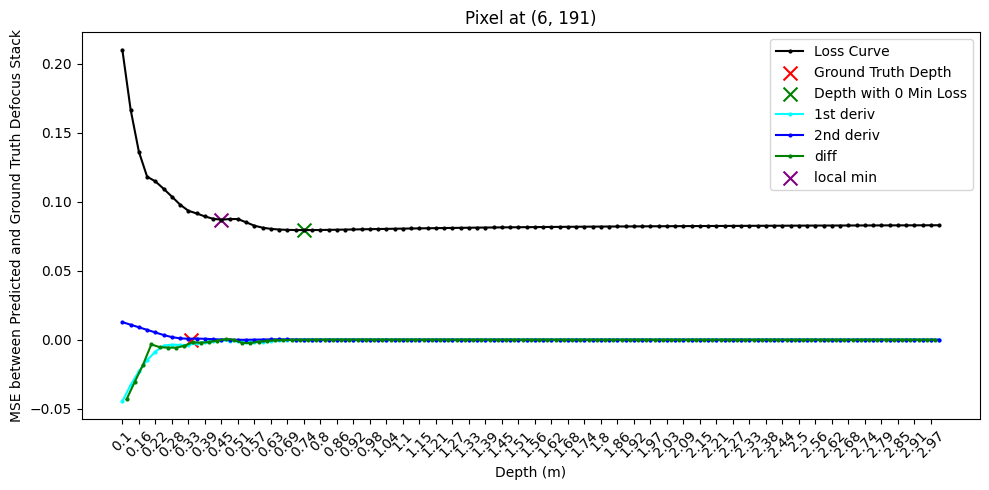

5 0.24646464 0.12948406 0.26366258


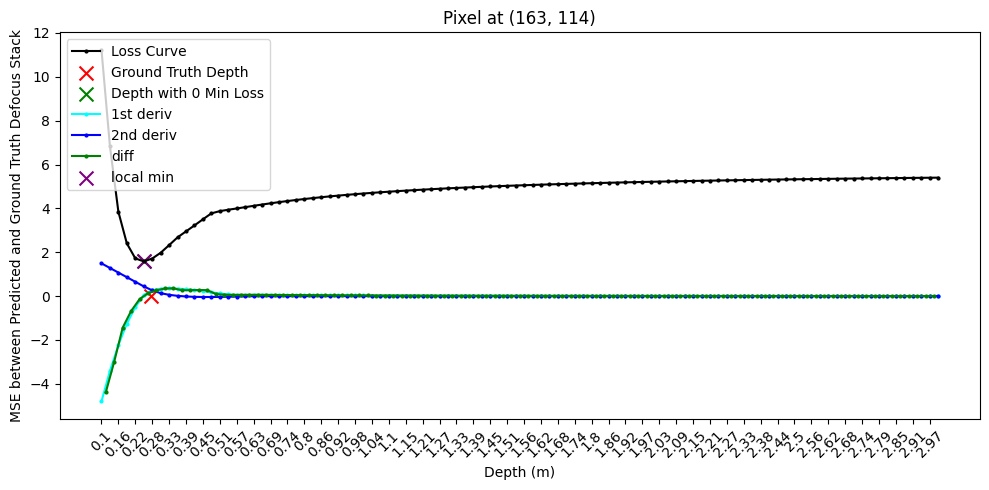

5 0.24646464 0.020458937 0.08013937


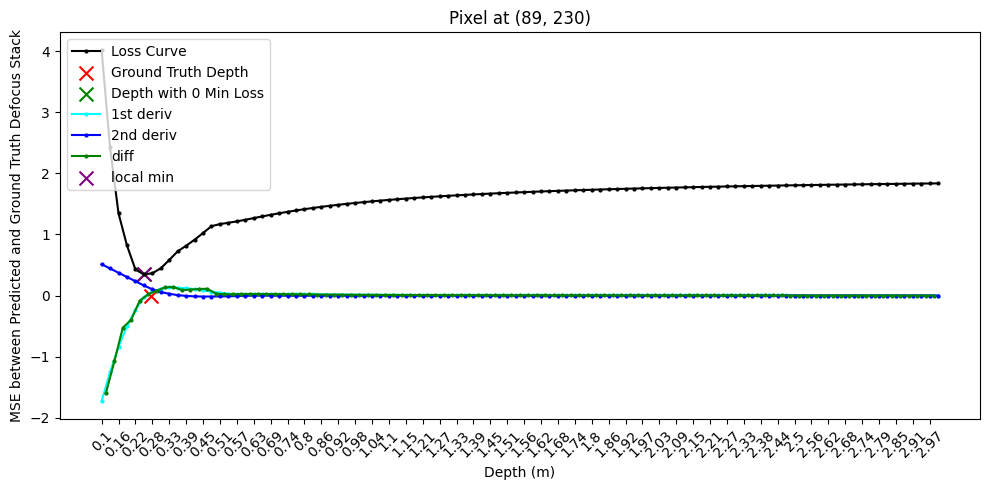

5 0.24646464 0.040223837 0.19100165


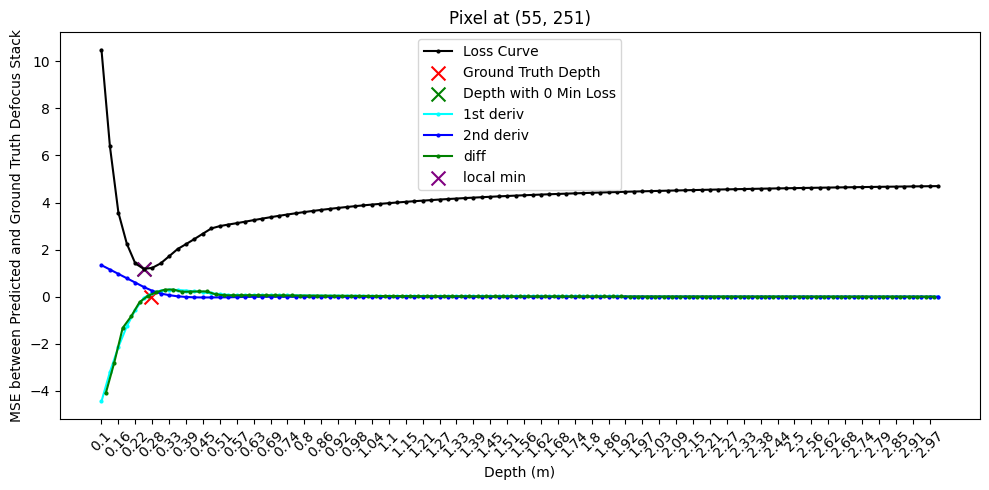

6 0.27575758 0.058784485 1.9574575


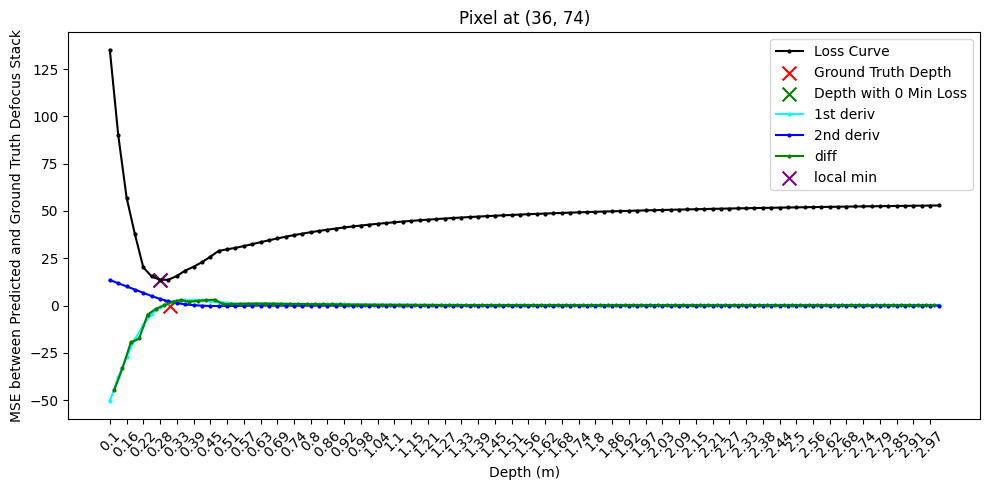

8 0.33434343 0.00068194047 0.00010858849


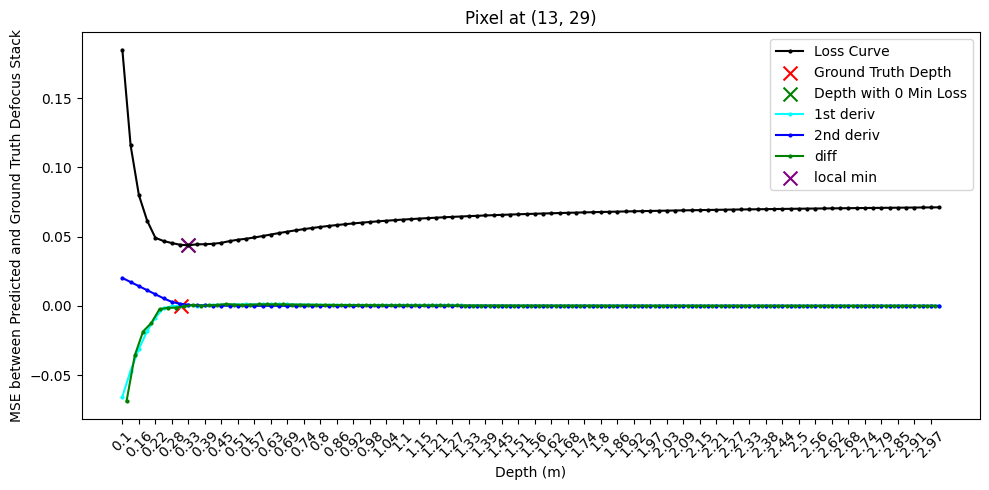

7 0.3050505 9.223819e-05 0.0016829483


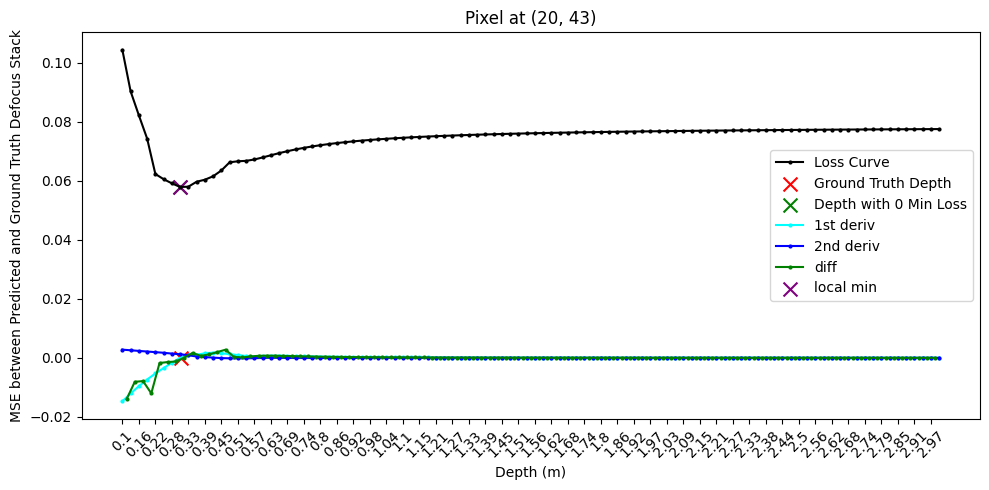

8 0.33434343 0.00014508516 -0.0002541989
9 0.36363637 -0.0002541989 -7.751584e-05
11 0.42222223 0.00041788444 0.0011673756


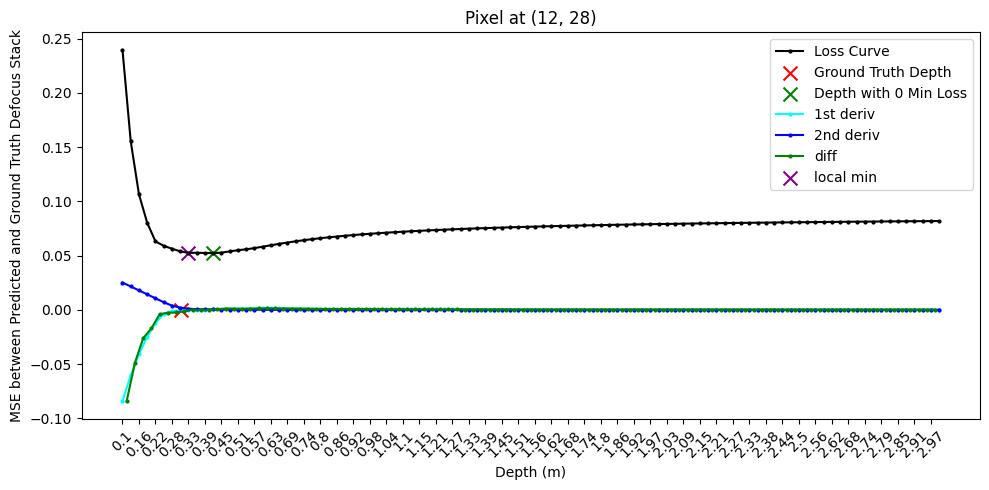

8 0.33434343 0.0004009772 0.0004670266


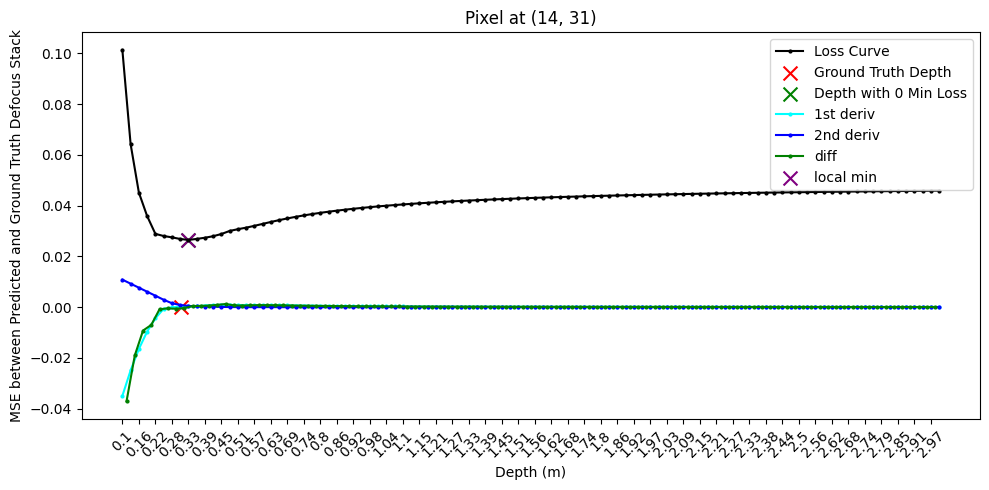

7 0.3050505 0.066290975 0.10410869


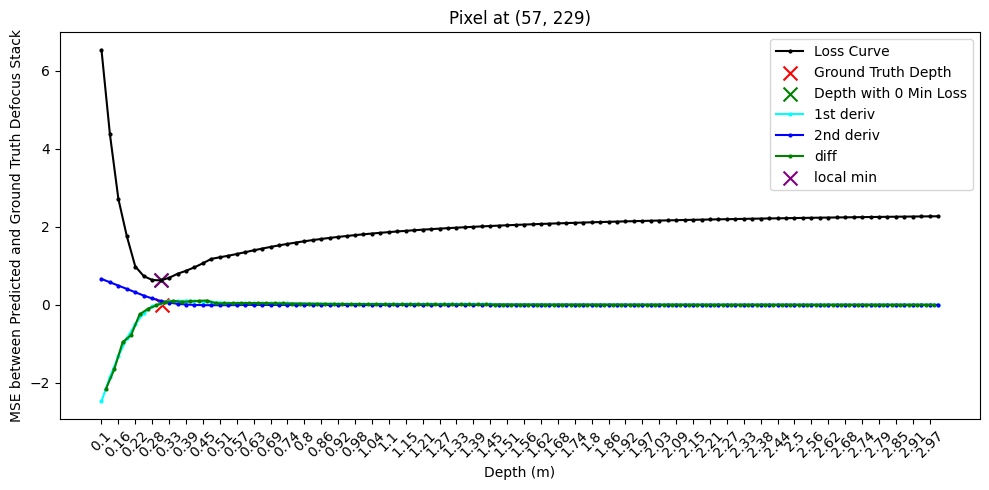

7 0.3050505 0.32080936 0.53652763


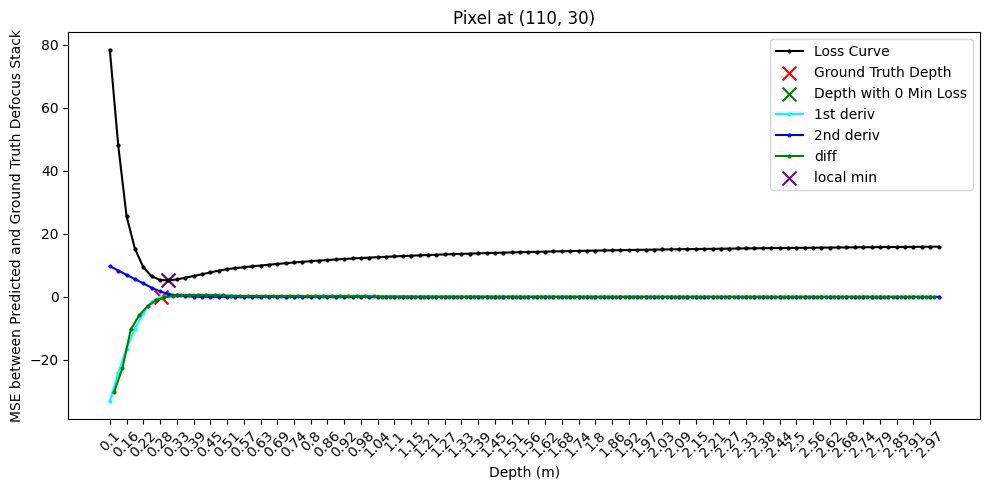

In [11]:
for i, j in worst_coords:
    utils.plot_grid_search_on_pixel(i, j, Z, all_losses, gt_dpt=gt_dpt,
                                k_min_indices=k_min_indices[i,j])

for i, j in best_coords:
    utils.plot_grid_search_on_pixel(i, j, Z, all_losses, gt_dpt=gt_dpt,
                                k_min_indices=k_min_indices[i,j])
    

In [ ]:
# instead of min loss what if we found area with highest magnitude second derivative 


In [ ]:
def strongest_curvature_region(i, j, all_losses, window=11):
    window = int(window)
    if window < 1:
        raise ValueError("window must be >= 1")
    if window % 2 == 0:
        window += 1
        
    losses = all_losses[i, j]
    d2 = np.gradient(np.gradient(losses))

    kernel = np.ones(window) / window
    avg_d2 = np.convolve(d2, kernel, mode="valid")

    # region with most negative average curvature
    start_valid = (window - 1) // 2
    center_offset = int(np.argmin(avg_d2))
    idx_center_region = start_valid + center_offset
    
    return idx_center_region

for i, j in worst_coords:
    idx_max_point, idx_min_point = strongest_curvature_region(i, j, all_losses, Z)
    print(Z[idx_max_point], Z[idx_min_point])